In [13]:
library(RColorBrewer)
library(readxl)
library(ggplot2)
library(dplyr)

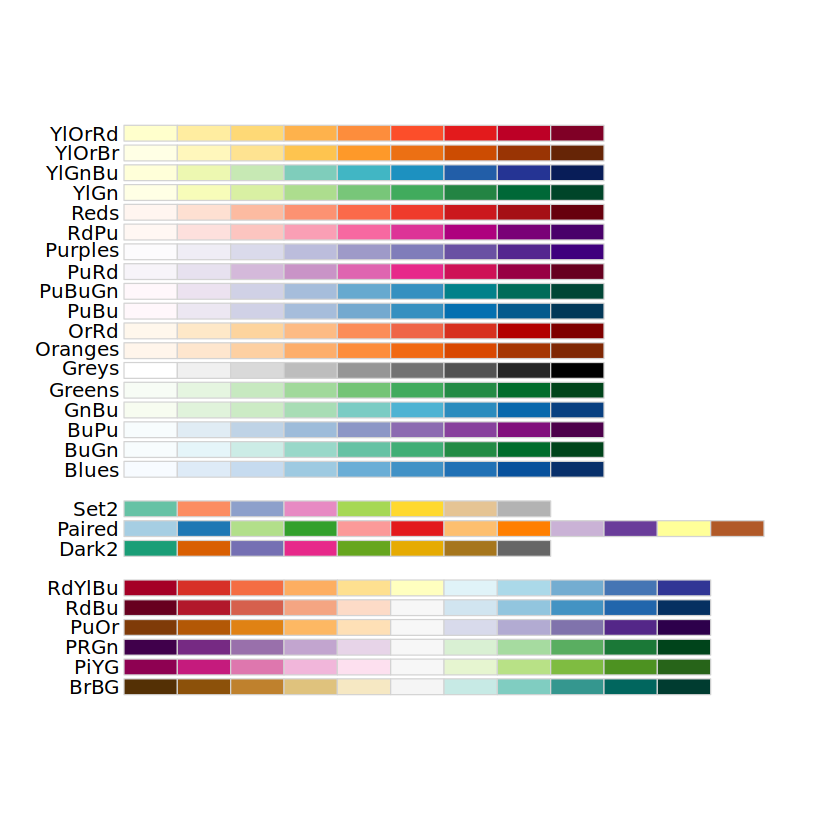

In [14]:
display.brewer.all(colorblindFriendly = TRUE)

In [15]:
# display.brewer.pal(n = 8, name = 'Dark2')
color_map_use = c(RColorBrewer::brewer.pal(8, "Dark2"))

### Common: read data excel

In [16]:
df = read_excel("/home/jinhyun/codes/geography_prediction/results/Geography prediction experiments.xlsx", sheet = "results_5M")

In [17]:
df

select_method,select_n,train_model,select_cpu_time,select_wall_time,select_memory_usage,train_cpu_time,train_wall_time,train_memory_usage,accuracy,f1_micro,f1_macro,f1_weighted,confusion matrix,remarks,PCA,tSNE
<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<lgl>,<lgl>,<lgl>
random,128,SVM,0.001748,0.002025,15.40693,0.007591,0.007471,15.43655,0.402496,0.402496,0.397324,0.401166,NA,NA,NA,NA
random,256,SVM,0.001424,0.002174,15.45327,0.010760,0.010577,15.46799,0.511700,0.511700,0.504933,0.510421,NA,NA,NA,NA
random,512,SVM,0.001502,0.002286,15.47381,0.019569,0.019607,15.49491,0.627145,0.627145,0.616102,0.623030,NA,NA,NA,NA
random,1024,SVM,0.001639,0.002502,15.49989,0.052247,0.052261,15.53595,0.711388,0.711388,0.690475,0.700628,NA,NA,NA,NA
random,2048,SVM,0.001612,0.002627,15.54132,0.129308,0.129316,15.58429,0.836193,0.836193,0.817732,0.829137,NA,NA,NA,NA
random,4096,SVM,0.001608,0.002602,15.55875,0.318077,0.318091,15.66268,0.858034,0.858034,0.842653,0.850888,NA,NA,NA,NA
random,8192,SVM,0.001380,0.002221,15.61958,0.670339,0.670234,15.93507,0.898596,0.898596,0.888690,0.895094,NA,NA,NA,NA
random,16384,SVM,0.002411,0.003378,15.73520,240.679600,3.767887,16.18242,0.904836,0.904836,0.885582,0.895672,NA,NA,NA,NA
random,32768,SVM,0.003507,0.004408,15.91887,234.574600,3.675932,16.93135,0.906396,0.906396,0.889998,0.898813,NA,NA,NA,NA


### Figure 2. Accuracy by n_select and selection method

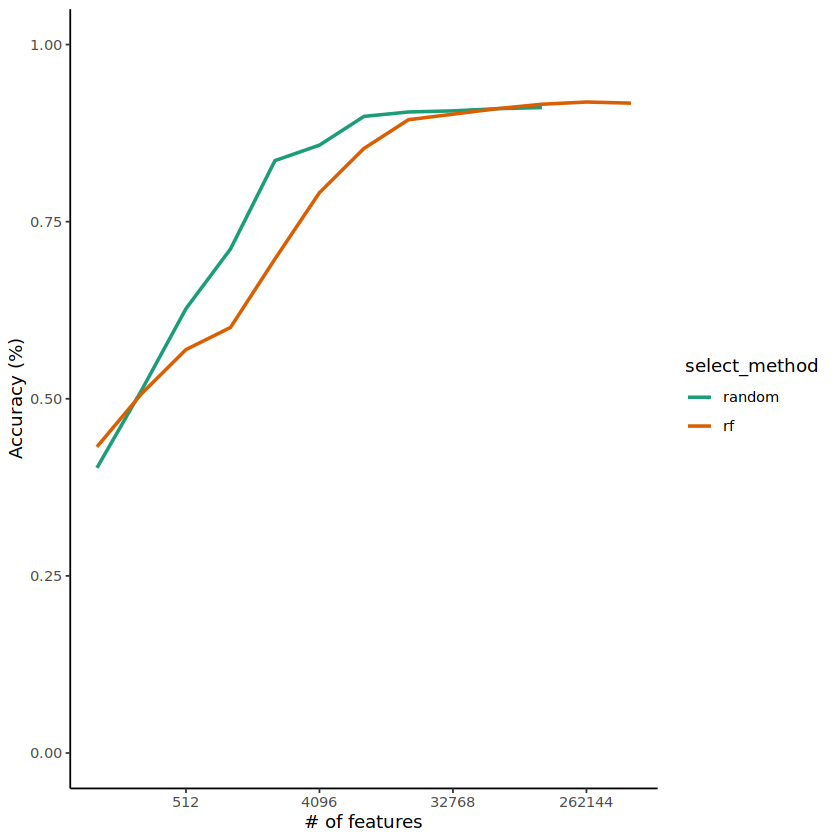

In [18]:
df_for_plot = df %>% filter(train_model == "SVM")
p = ggplot(data = df_for_plot, aes(x = select_n, y = accuracy, group = select_method, colour = select_method)) +
  geom_line(linewidth = 1) +
  xlab("# of features") + 
  ylab("Accuracy (%)") +
  scale_color_brewer(palette = "Dark2") +
  scale_x_continuous(trans='log2') +
  scale_y_continuous(limits = c(0,1)) +
  theme_bw() + 
  theme(panel.border = element_blank(), panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(), axis.line = element_line(colour = "black")); 
        print(p)

#ggsave("processing per cost.pdf", width=11.2, height=8, units = c("cm"), dpi = 300)

### Supplementary Fig. Accuracy by train_model

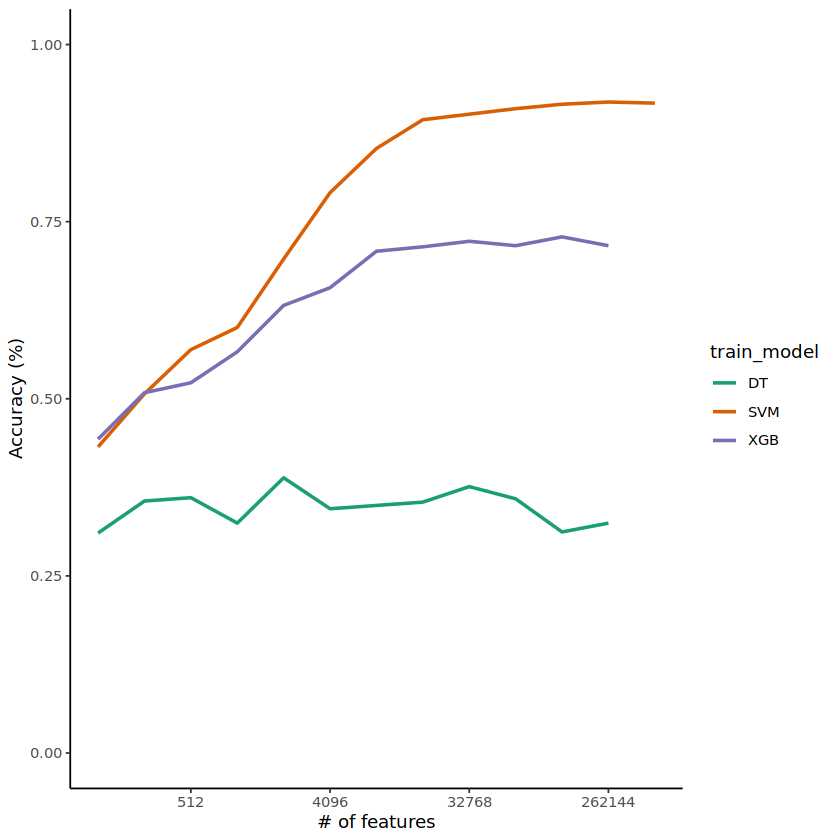

In [9]:
df_for_plot = df %>% filter(select_method == "rf")
p = ggplot(data = df_for_plot, aes(x = select_n, y = accuracy, group = train_model, colour = train_model)) +
  geom_line(linewidth = 1) +
  xlab("# of features") + 
  ylab("Accuracy (%)") +
  scale_color_brewer(palette = "Dark2") +
  scale_x_continuous(trans='log2') +
  scale_y_continuous(limits = c(0,1)) +
  theme_bw() + 
  theme(panel.border = element_blank(), panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(), axis.line = element_line(colour = "black")); 
        print(p)

### Resources by n_select and method

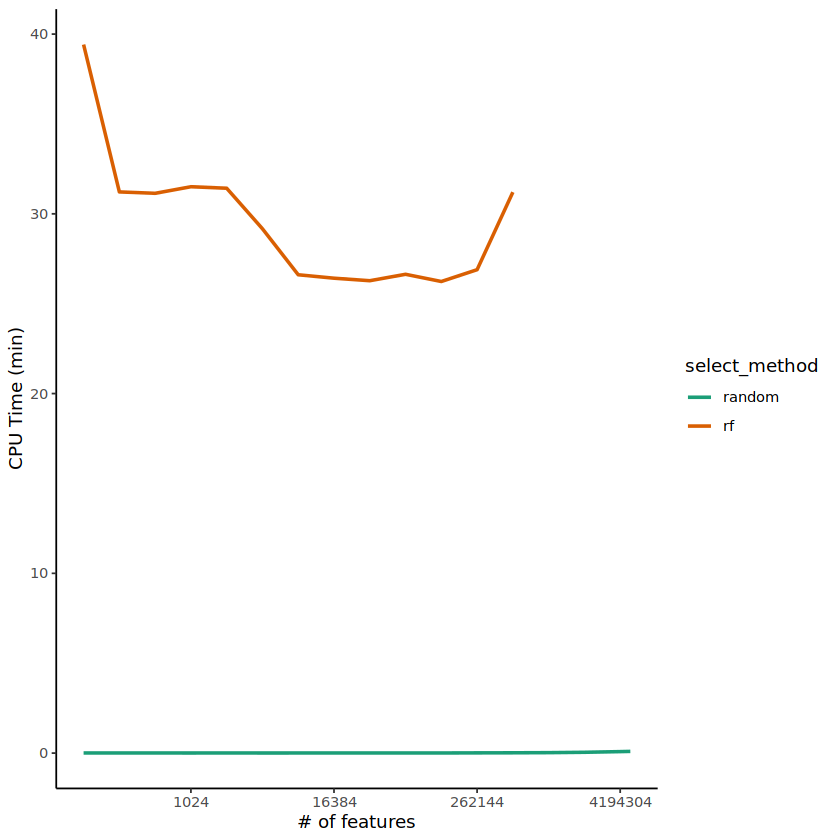

In [11]:
p = ggplot(data = df, aes(x = select_n, y = select_cpu_time, group = select_method, colour = select_method)) +
  geom_line(linewidth = 1) +
  xlab("# of features") + 
  ylab("CPU Time (min)") +
  scale_color_brewer(palette = "Dark2") +
  scale_x_continuous(trans='log2') +
  theme_bw() + 
  theme(panel.border = element_blank(), panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(), axis.line = element_line(colour = "black")); 
        print(p)

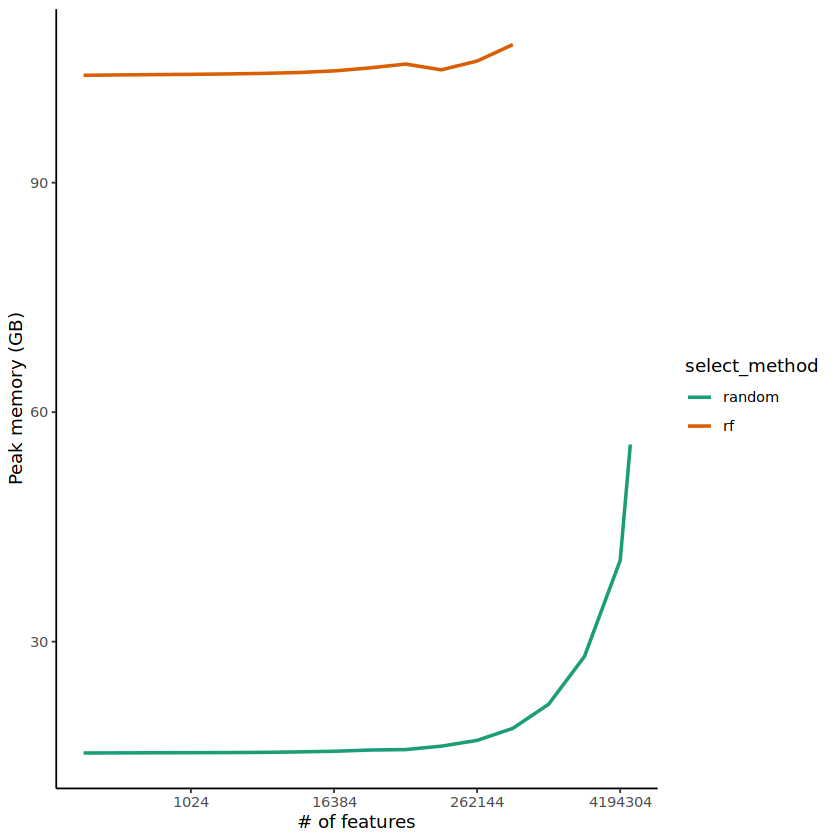

In [12]:
p = ggplot(data = df, aes(x = select_n, y = select_memory_usage, group = select_method, colour = select_method)) +
  geom_line(linewidth = 1) +
  xlab("# of features") + 
  ylab("Peak memory (GB)") +
  scale_color_brewer(palette = "Dark2") +
  scale_x_continuous(trans='log2') +
  theme_bw() + 
  theme(panel.border = element_blank(), panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(), axis.line = element_line(colour = "black")); 
        print(p)